# 6) Using Gambit with OpenSpiel

This tutorial demonstrates the interoperability of the Gambit and OpenSpiel Python packages for game-theoretic analysis.

Where Gambit is used to compute exact equilibria for games, OpenSpiel provides a variety of iterative learning algorithms that can be used to approximate strategies. Another key distinction is that the PyGambit API allows the user a simple way to define custom games (see tutorials 1-3). This is also possible in OpenSpiel for normal form games, and you can load `.efg` files created from Gambit for extensive form, however some of the key functionality for iterated learning of strategies is only available for games from the built-in library (see the [OpenSpiel documentation](https://openspiel.readthedocs.io/en/latest/games.html)).

This tutorial demonstrates:

1. Transferring examples of normal (strategic) form and extensive form games between OpenSpiel and Gambit
2. Simulating evolutionary dynamics of populations of strategies in OpenSpiel for normal form games
3. Training agents using self-play of extensive form games in OpenSpiel to create strategies
4. Comparing the strategies from OpenSpiel against equilibria strategies computed with Gambit

Note:
- The version of OpenSpiel used in this tutorial is `1.6.1`. If you are running this tutorial locally, this will be the version installed via the included `requirements.txt` file.
- The OpenSpiel code was adapted from the introductory tutorial for the OpenSpiel API on colab [here](https://colab.research.google.com/github/deepmind/open_spiel/blob/master/open_spiel/colabs/OpenSpielTutorial.ipynb).

In [2]:
from io import StringIO
import numpy as np
import matplotlib.pyplot as plt

from open_spiel.python import rl_environment
from open_spiel.python.algorithms import tabular_qlearner
from open_spiel.python.algorithms.gambit import export_gambit
from open_spiel.python.egt import dynamics
from open_spiel.python.egt.utils import game_payoffs_array

import pyspiel

import pygambit as gbt

## OpenSpiel game library

The [library of games](https://openspiel.readthedocs.io/en/latest/games.html) included in OpenSpiel is extensive. Many of these games will not be amenable to equilibrium computation with Gambit, due to their size. For the purposes of this tutorial, we'll pick small games from the list below.

In [3]:
print(pyspiel.registered_names())

['2048', 'add_noise', 'amazons', 'backgammon', 'bargaining', 'battleship', 'blackjack', 'blotto', 'breakthrough', 'bridge', 'bridge_uncontested_bidding', 'cached_tree', 'catch', 'checkers', 'chess', 'cliff_walking', 'clobber', 'coin_game', 'colored_trails', 'connect_four', 'coop_box_pushing', 'coop_to_1p', 'coordinated_mp', 'crazy_eights', 'cribbage', 'cursor_go', 'dark_chess', 'dark_hex', 'dark_hex_ir', 'deep_sea', 'dots_and_boxes', 'dou_dizhu', 'efg_game', 'einstein_wurfelt_nicht', 'euchre', 'first_sealed_auction', 'gin_rummy', 'go', 'goofspiel', 'hanabi', 'havannah', 'hearts', 'hex', 'hive', 'kriegspiel', 'kuhn_poker', 'laser_tag', 'leduc_poker', 'lewis_signaling', 'liars_dice', 'liars_dice_ir', 'lines_of_action', 'maedn', 'mancala', 'markov_soccer', 'matching_pennies_3p', 'matrix_bos', 'matrix_brps', 'matrix_cd', 'matrix_coordination', 'matrix_mp', 'matrix_pd', 'matrix_rps', 'matrix_rpsw', 'matrix_sh', 'matrix_shapleys_game', 'mfg_crowd_modelling', 'mfg_crowd_modelling_2d', 'mfg_dy

## Normal form games from the OpenSpiel library

Let's start with a simple normal form game of rock-paper-scissors, in which the payoffs can be represented by a 3x3 matrix.

Load matrix rock-paper-scissors from OpenSpiel:

In [4]:
ops_matrix_rps_game = pyspiel.load_game("matrix_rps")

In order to simulate a playthrough of the game, you can first initialise a game state:

In [5]:
state = ops_matrix_rps_game.new_initial_state()
state

Terminal? false
Row actions: Rock Paper Scissors 
Col actions: Rock Paper Scissors 
Utility matrix:
0,0 -1,1 1,-1 
1,-1 0,0 -1,1 
-1,1 1,-1 0,0 

The possible actions for both players (player 0 and player 1) are Rock, Paper and Scissors, but these are not labelled and must be accessed via integer indices:

In [6]:
print(state.legal_actions(0)) # Player 0 (row) actions
print(state.legal_actions(1)) # Player 1 (column) actions

[0, 1, 2]
[0, 1, 2]


Since Rock-paper-scissors is a 1-step simultaneous-move normal form game, we'll apply a list of player actions in one step to reach the terminal state.

Let's simulate player 0 playing Rock (0) and player 1 playing Paper (1):

In [7]:
state.apply_actions([0, 1])
state

Terminal? true
History: 0, 1
Returns: -1,1
Row actions: 
Col actions: 
Utility matrix:
0,0 -1,1 1,-1 
1,-1 0,0 -1,1 
-1,1 1,-1 0,0 

OpenSpiel can generate an NFG representation of the game loadable in Gambit:

In [8]:
nfg_matrix_rps_game = pyspiel.game_to_nfg_string(ops_matrix_rps_game)
nfg_matrix_rps_game

'NFG 1 R "OpenSpiel export of matrix_rps()"\n{ "Player 0" "Player 1" } { 3 3 }\n\n0 0\n1 -1\n-1 1\n-1 1\n0 0\n1 -1\n1 -1\n-1 1\n0 0\n'

Now let's load the NFG in Gambit. Since Gambit's `read_nfg` function expects a file like object, we'll convert the string with `io.StringIO`.
We can also add labels for the actions to make the output more interpretable.

In [9]:
gbt_matrix_rps_game = gbt.read_nfg(StringIO(nfg_matrix_rps_game))

gbt_matrix_rps_game.title = "Rock-Paper-Scissors"

for player in gbt_matrix_rps_game.players:
    player.strategies[0].label = "Rock"
    player.strategies[1].label = "Paper"
    player.strategies[2].label = "Scissors"

gbt_matrix_rps_game

,Rock,Paper,Scissors
Rock,"0,0","-1,1","1,-1"
Paper,"1,-1","0,0","-1,1"
Scissors,"-1,1","1,-1","0,0"


The equilibrium strategy for both players is to choose rock, paper, and scissors with equal probability:

In [10]:
gbt.nash.lcp_solve(gbt_matrix_rps_game).equilibria[0]

[[Rational(1, 3), Rational(1, 3), Rational(1, 3)], [Rational(1, 3), Rational(1, 3), Rational(1, 3)]]

We can use OpenSpiel's dynamics module to demonstrate evolutionary game theory dynamics, or "replicator dynamics", which models how strategy population frequencies change over time based on relative fitness/payoffs.

Let's start with an initial population that is not at equilibrium, but weighted towards scissors with proportions: 30% Rock, 30% Paper, 40% Scissors:

In [42]:
matrix_rps_payoffs = game_payoffs_array(ops_matrix_rps_game)
dyn = dynamics.SinglePopulationDynamics(matrix_rps_payoffs, dynamics.replicator)
x = np.array([0.3, 0.3, 0.4])
dyn(x)

array([ 0.03, -0.03,  0.  ])

`dyn(x)` calculates the rate of change (derivative) for each strategy in the current population state and returns how fast each strategy's frequency is changing.

In replicator dynamics, strategies that perform better than average will increase in frequency, while strategies performing worse will decrease.
In our rock-paper-scissors example, the performance of each strategy depends on the distribution of strategies in the population. For example, if there are many players using scissors, then rock will perform well and increase in frequency, while paper will perform poorly and decrease. Over time, as the population proportions change, the performance of each strategy will also change.

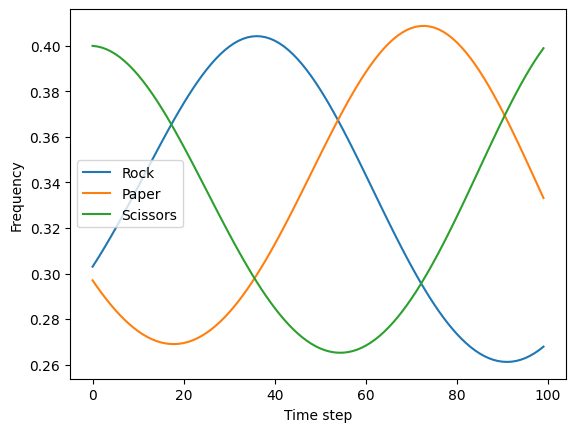

In [40]:
def plot_rps_dynamics(proportions, steps=100, alpha=0.1, plot_average_strategy=False):
    x = np.array(proportions)
    rock_proportions = [x[0]]
    paper_proportions = [x[1]]
    scissors_proportions = [x[2]]
    y = []
    for _ in range(steps):
        x += alpha * dyn(x)
        rock_proportions.append(x[0])
        paper_proportions.append(x[1])
        scissors_proportions.append(x[2])
        if plot_average_strategy:
            y.append([np.mean(rock_proportions), np.mean(paper_proportions), np.mean(scissors_proportions)])
        else:
            y.append(x.copy())
    y = np.array(y)

    plt.plot(y[:, 0], label="Rock")
    plt.plot(y[:, 1], label="Paper")
    plt.plot(y[:, 2], label="Scissors")
    plt.xlabel("Time step")
    plt.ylabel("Frequency")
    plt.legend()
    plt.show()

plot_rps_dynamics([0.3, 0.3, 0.4])

Through the dynamics, we can see that the population proportions oscillate around the equilibrium point (1/3, 1/3, 1/3) without converging to it, because the best strategy depends on the likelihood of the opponents' actions, as defined by the current population proportions.

However, if we start with the initial population already in equilibrium computed by Gambit (1/3 each), the frequencies will remain constant over time:

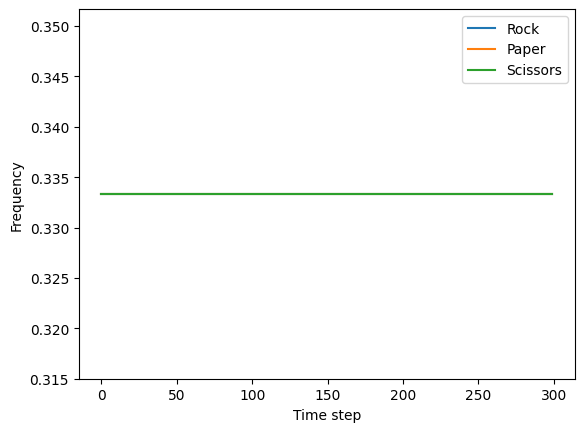

In [37]:
plot_rps_dynamics([1/3, 1/3, 1/3])

Though the strategies themeselves never reach equilibrium when stating from an unbalacned initial population, we can plot the average strategy proportions across steps (over time), where we can see that they begin to converge to the equilibrium point:

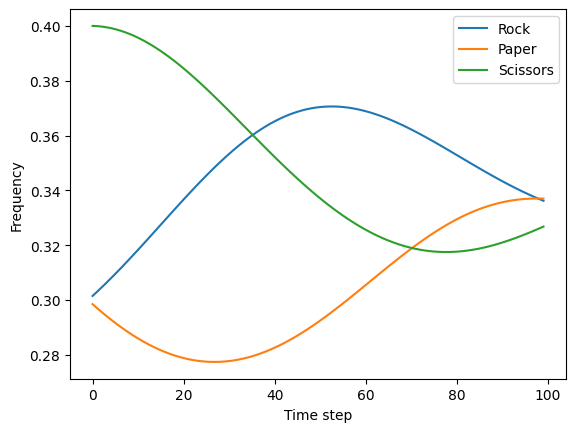

In [41]:
plot_rps_dynamics([0.3, 0.3, 0.4], plot_average_strategy=True)

## Normal form games created with Gambit

You can also set up a normal form game in Gambit and export it to OpenSpiel. Here we demonstrate this with the Prisoner's Dilemma game from tutorial 1.

In [ ]:
gbt_prisoners_dilemma_game = gbt.read_nfg("games/prisoners_dilemma.nfg")
gbt_prisoners_dilemma_game

,Cooperate,Defect
Cooperate,"-1,-1","-3,0"
Defect,"0,-3","-2,-2"


In [ ]:
gbt.nash.lcp_solve(gbt_prisoners_dilemma_game).equilibria[0]

[[Rational(0, 1), Rational(1, 1)], [Rational(0, 1), Rational(1, 1)]]

As expected, Gambit computes the equilibrium strategy for both players as choosing cooperate with probability 0 and defect with probability 1.

To re-create the game in OpenSpiel we extract the player payoffs to NumPy arrays, which are then used to create a matrix game in OpenSpiel:

In [ ]:
p1_payoffs, p2_payoffs = gbt_prisoners_dilemma_game.to_arrays(dtype=float)
ops_prisoners_dilemma_game = pyspiel.create_matrix_game(
    gbt_prisoners_dilemma_game.title,
    "Classic Prisoner's Dilemma",  # description
    [strategy.label for strategy in gbt_prisoners_dilemma_game.players[0].strategies],
    [strategy.label for strategy in gbt_prisoners_dilemma_game.players[1].strategies],
    p1_payoffs,
    p2_payoffs
)

Like rock-paper-scissors, the Prisoner's Dilemma is a 1-step simultaneous-move normal form game; we'll apply a list of player actions in one step to reach the terminal state. Let's have both player choose to defect (1):

In [ ]:
state = ops_prisoners_dilemma_game.new_initial_state()
state.apply_actions([1, 1])
state

Terminal? true
History: 1, 1
Returns: -2,-2
Row actions: 
Col actions: 
Utility matrix:
-1,-1 -3,0 
0,-3 -2,-2 

Unlike in rock-paper-scissors, the Prisoner's Dilemma has a dominant strategy equilibrium, in which both players defect.
Using evolutionary dynamics, we can see that a population starting with a mix of cooperators and defectors will evolve towards all defectors over time:

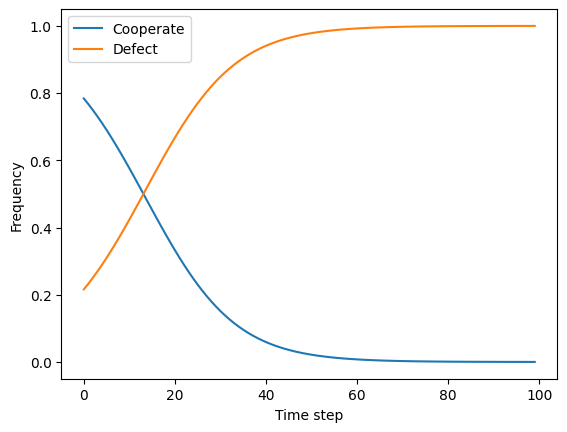

In [ ]:
matrix_pd_payoffs = game_payoffs_array(ops_prisoners_dilemma_game)
pd_dyn = dynamics.SinglePopulationDynamics(matrix_pd_payoffs, dynamics.replicator)

def plot_pd_dynamics(proportions, steps=100, alpha=0.1):
    x = np.array(proportions)
    y = []
    for _ in range(steps):
        x += alpha * pd_dyn(x)
        y.append(x.copy())
    y = np.array(y)
    plt.plot(y[:, 0], label="Cooperate")
    plt.plot(y[:, 1], label="Defect")
    plt.xlabel("Time step")
    plt.ylabel("Frequency")
    plt.legend()
    plt.show()

plot_pd_dynamics([0.8, 0.2])

<!-- ## Extensive form example: Silly1111 Poker -->

<!-- Silly poker is a variant imperfect information one-card poker game introduced in tutorial 3, but in which there are 3 possible cards (J, Q, K) instead of 2. -->

## Extensive form games from the OpenSpiel library

For extensive form games, OpenSpiel can export to the EFG format used by Gambit. Here we demonstrate this with **Tiny Hanabi**, loaded from the OpenSpiel [game library](https://openspiel.readthedocs.io/en/latest/games.html).

In [ ]:
ops_hanabi_game = pyspiel.load_game("tiny_hanabi")
efg_hanabi_game = export_gambit(ops_hanabi_game)
efg_hanabi_game

'EFG 2 R "tiny_hanabi()" { "Pl0" "Pl1" } \nc "" 1 "" { "d0" 0.5000000000000000 "d1" 0.5000000000000000  } 0\n c "p0:d0" 2 "" { "d0" 0.5000000000000000 "d1" 0.5000000000000000  } 0\n  p "" 1 1 "" { "p0a0" "p0a1" "p0a2"  } 0\n   p "" 2 1 "" { "p1a0" "p1a1" "p1a2"  } 0\n    t "" 1 "" { 10.0 10.0 }\n    t "" 2 "" { 0.0 0.0 }\n    t "" 3 "" { 0.0 0.0 }\n   p "" 2 2 "" { "p1a0" "p1a1" "p1a2"  } 0\n    t "" 4 "" { 4.0 4.0 }\n    t "" 5 "" { 8.0 8.0 }\n    t "" 6 "" { 4.0 4.0 }\n   p "" 2 3 "" { "p1a0" "p1a1" "p1a2"  } 0\n    t "" 7 "" { 10.0 10.0 }\n    t "" 8 "" { 0.0 0.0 }\n    t "" 9 "" { 0.0 0.0 }\n  p "" 1 1 "" { "p0a0" "p0a1" "p0a2"  } 0\n   p "" 2 4 "" { "p1a0" "p1a1" "p1a2"  } 0\n    t "" 10 "" { 0.0 0.0 }\n    t "" 11 "" { 0.0 0.0 }\n    t "" 12 "" { 10.0 10.0 }\n   p "" 2 5 "" { "p1a0" "p1a1" "p1a2"  } 0\n    t "" 13 "" { 4.0 4.0 }\n    t "" 14 "" { 8.0 8.0 }\n    t "" 15 "" { 4.0 4.0 }\n   p "" 2 6 "" { "p1a0" "p1a1" "p1a2"  } 0\n    t "" 16 "" { 0.0 0.0 }\n    t "" 17 "" { 0.0 0.0

Now let's load the EFG in Gambit.
We can then compute equilibria strategies for the players as usual.

In [ ]:
gbt_hanabi_game = gbt.read_efg(StringIO(efg_hanabi_game))
eqm = gbt.nash.lcp_solve(gbt_hanabi_game).equilibria[0]
for player in gbt_hanabi_game.players:
    print(player.label)

Pl0
Pl1


We can look at player 0's equilibrium strategy:

In [ ]:
eqm['Pl0']

[[Rational(0, 1), Rational(0, 1), Rational(1, 1)], [Rational(0, 1), Rational(1, 1), Rational(0, 1)]]

...and use Gambit to explore what those numbers actually mean for player 0:

In [ ]:
for infoset, mixed_action in eqm["Pl0"].mixed_actions():
    print(
        f"At information set {infoset.number}, "
        f"Player 0 plays action 0 with probability: {mixed_action['p0a0']}"
        f" and action 1 with probability: {mixed_action['p0a1']}"
        f" and action 2 with probability: {mixed_action['p0a2']}"
    )

At information set 0, Player 0 plays action 0 with probability: 0 and action 1 with probability: 0 and action 2 with probability: 1
At information set 1, Player 0 plays action 0 with probability: 0 and action 1 with probability: 1 and action 2 with probability: 0


For player 1, we can do the same:

In [ ]:
eqm['Pl1']

[[Rational(0, 1), Rational(0, 1), Rational(1, 1)], [Rational(0, 1), Rational(1, 1), Rational(0, 1)], [Rational(1, 1), Rational(0, 1), Rational(0, 1)], [Rational(0, 1), Rational(0, 1), Rational(1, 1)], [Rational(0, 1), Rational(1, 1), Rational(0, 1)], [Rational(0, 1), Rational(0, 1), Rational(1, 1)]]

In [ ]:
for infoset, mixed_action in eqm["Pl1"].mixed_actions():
    print(
        f"At information set {infoset.number}, "
        f"Player 1 plays action 0 with probability: {mixed_action['p1a0']}"
        f" and action 1 with probability: {mixed_action['p1a1']}"
        f" and action 2 with probability: {mixed_action['p1a2']}"
    )

At information set 0, Player 1 plays action 0 with probability: 0 and action 1 with probability: 0 and action 2 with probability: 1
At information set 1, Player 1 plays action 0 with probability: 0 and action 1 with probability: 1 and action 2 with probability: 0
At information set 2, Player 1 plays action 0 with probability: 1 and action 1 with probability: 0 and action 2 with probability: 0
At information set 3, Player 1 plays action 0 with probability: 0 and action 1 with probability: 0 and action 2 with probability: 1
At information set 4, Player 1 plays action 0 with probability: 0 and action 1 with probability: 1 and action 2 with probability: 0
At information set 5, Player 1 plays action 0 with probability: 0 and action 1 with probability: 0 and action 2 with probability: 1


Let's now train 2 agents using independent Q-learning on Tiny Hanabi, and play them against eachother.

We can compare the learned strategies played to the equilibrium strategies computed by Gambit.

First let's open the RL environment for Tiny Hanabi and create the agents, one for each player (2 players in this case):

In [ ]:
# Create the environment
env = rl_environment.Environment("tiny_hanabi")
num_players = env.num_players
num_actions = env.action_spec()["num_actions"]

# Create the agents
agents = [
    tabular_qlearner.QLearner(player_id=idx, num_actions=num_actions)
    for idx in range(num_players)
]

Now we can train the Q-learning agents in self-play.

In [ ]:
for cur_episode in range(30000):
  if cur_episode % 10000 == 0:
    print(f"Episodes: {cur_episode}")

  time_step = env.reset()
  while not time_step.last():
    player_id = time_step.observations["current_player"]
    agent_output = agents[player_id].step(time_step)
    time_step = env.step([agent_output.action])

  # Episode is over, step all agents with final info state.
  for agent in agents:
    agent.step(time_step)

print(f"Episodes: {cur_episode+1}")

Episodes: 0
Episodes: 10000
Episodes: 20000
Episodes: 30000


Let's check out the strategies our agents have learned by playing them against eachother again, this time in evaluation mode (setting `is_evaluation=True`):

In [ ]:
time_step = env.reset()

while not time_step.last():
  print("")
  print(env.get_state)

  player_id = time_step.observations["current_player"]
  agent_output = agents[player_id].step(time_step, is_evaluation=True)
  print(f"Agent {player_id} chooses {env.get_state.action_to_string(agent_output.action)}")
  time_step = env.step([agent_output.action])

print("")
print(env.get_state)
print(f"Rewards: {time_step.rewards}")


p0:d0 p1:d0
Agent 0 chooses p0a0

p0:d0 p1:d0 p0:a0
Agent 1 chooses p1a0

p0:d0 p1:d0 p0:a0 p1:a0
Rewards: [10.0, 10.0]


Are the learned strategies chosen by p0 and p1 consistent with an equilibrium computed by Gambit?

When I ran the above I got the final game state `p0:d0 p1:d0 p0:a2 p1:a0` with payoffs `[10.0, 10.0]`. This is consistent with the equilibrium computed by Gambit:
- The node `p0:d0 p1:d0` is part of player 0's information set 0.
- p0 picks a2 which matches the first equilibrium strategy in `eqm['Pl0']` where action `p0a2` is played with probability 1.0.
- This puts player 1 in their information set 2, and player 1 picks action 0, which is consistent with `eqm['Pl1']` where action `p1a0` is played with probability 1.0.

## Extensive form games created with Gambit

It's also possible to create an extensive form game in Gambit and export it to OpenSpiel. Here we demonstrate this with the one-card poker game introduced in tutorial 3.

In [ ]:
with open("../poker.efg", "r") as f:
    poker_efg_string = f.read()
    ops_one_card_poker = pyspiel.load_efg_game(poker_efg_string)
ops_one_card_poker

efg_game()

Games loaded from EFG in OpenSpiel do not take advantage of the full functionality of the package, for example, it is not possible to carry out training with RL algorithms on these games, as in the example above with Tiny Hanabi. The OpenSpiel documentation explains [how to submit new games to the library](https://openspiel.readthedocs.io/en/latest/developer_guide.html#adding-a-game) if you wish to add your own games.

We can however use the state representation and play through the game step by step:

In [ ]:
ops_one_card_poker.num_distinct_actions()

4

The one-card poker game has 4 distinct actions, 2 are for the first player (Alice in the example game): "Raise" and "Fold", and 2 for the second player (Bob): "Meet" and "Pass".

Initialising the game state, we can see the current player at the start is the chance player, who deals the cards:

In [ ]:
state = ops_one_card_poker.new_initial_state()
state

0: Chance:  1  King 0.5 Queen 0.5

Let's make the chance player's action dealing a King (action 0):

In [ ]:
state.apply_action(0)
state

1: Player:  1 1  Raise Fold

As expected, it's now the first player's (Alice's) turn.
Let's have Alice choose to "Raise" (action 0):

In [ ]:
state.apply_action(0)
state

3: Player:  2 1  Meet Pass

As expected, the current player is now player 2 (Bob), let's check the legal actions available to Bob:

In [ ]:
state.legal_actions()

[2, 3]

Whereas player 1 (Alice) had the option to "Raise" (action 0) and "Fold" (action 1), player 2 (Bob) now has the option to "Meet" (action 2) or "Pass" (action 3).
Let's have Bob choose to "Pass":

In [ ]:
state.apply_action(3)
state

6: Terminal:  Alice wins 1 -1

Since Bob passed, Alice takes the small win and we reach a terminal state.